# Machine Learning - Final assignment

**Students:**
<hr>
Mutaz Abueisheh</br>
Marcelo Jose Ferrer</br>
Maximiliano Hormazábal Lagos</br>
Mohamed Aymen Merchaoui</br>

## Classification problem

Classify the dataset between this 10 classes.

0 = Acoustic/Folk</br>
1 = Alternative music</br>
2 = Blues</br>
3 = Bollywood</br>
4 = Country</br>
5 = Hip Hop</br>
6 = Indie</br>
7 = Instrumental</br>
8 = Metal</br>
9 = Pop</br>
10 = Rock</br>

https://www.kaggle.com/datasets/purumalgi/music-genre-classification

# Imports and declarations

This section contains all imports and declarations

In [1]:
# The next packages must be installed to run the solution
import Pkg; 
#Pkg.add("Flux")
#Pkg.add("RDatasets")
#Pkg.add("FeatureSelectors")
#Pkg.add("ScikitLearn")
#Pkg.add("WeightedPCA")
#Pkg.add("BetaML")
# Packages used To store and load models in and from disk
#Pkg.add("JLD")
#Pkg.add("HDF5")
#Pkg.add("PyCallJLD")
# Package use to count distribution
#Pkg.add("DataStructures")
#Pkg.add("MLDataPattern")
# Packages used to make graphic representations
# Pkg.add("Plots")
# Pkg.add("StatsPlots")

In [2]:
# Import libraries
using Flux
using Flux.Losses
using DelimitedFiles
using Statistics
using Random
using ScikitLearn
using JLD
using PyCallJLD
using Plots
using StatsPlots

In [ ]:
# Import ScikitLearn models
# Basic models
@sk_import svm:SVC
@sk_import tree:DecisionTreeClassifier
@sk_import neural_network:MLPClassifier
@sk_import neighbors:KNeighborsClassifier
@sk_import naive_bayes:GaussianNB 
@sk_import linear_model:LogisticRegression
@sk_import neighbors:NearestCentroid
@sk_import neighbors:RadiusNeighborsClassifier
@sk_import linear_model:RidgeClassifier

# Ensemble models
@sk_import ensemble:VotingClassifier
@sk_import ensemble:StackingClassifier
@sk_import ensemble:BaggingClassifier
@sk_import ensemble:RandomForestClassifier
@sk_import ensemble:AdaBoostClassifier
@sk_import ensemble:GradientBoostingClassifier

┌ Info: Running `conda install -y -c conda-forge 'libstdcxx-ng>=3.4,<11.4'` in root environment
└ @ Conda /root/.julia/packages/Conda/x2UxR/src/Conda.jl:127


Solving environment: ...working... done

# All requested packages already installed.



┌ Info: Running `conda install -y -c conda-forge 'libstdcxx-ng>=3.4,<11.4'` in root environment
└ @ Conda /root/.julia/packages/Conda/x2UxR/src/Conda.jl:127


Solving environment: ...working... done

# All requested packages already installed.



┌ Info: Running `conda install -y -c conda-forge 'libstdcxx-ng>=3.4,<11.4'` in root environment
└ @ Conda /root/.julia/packages/Conda/x2UxR/src/Conda.jl:127


In [4]:
# Legacy code done in previous practices
include("utils/practices_code.jl")
# Class that handle the model processing
include("utils/model_handler.jl")

loadModel (generic function with 1 method)

# Constants

In [5]:
# Path of the best models that where created in the testing and experimentation notebook
ANN_FILE_PATH = "dataset/models/ann.jld"
SVM_FILE_PATH = "dataset/models/svm.jld"
DT_FILE_PATH = "dataset/models/dt.jld"
KNN_FILE_PATH = "dataset/models/knn.jld"
MLP_FILE_PATH = "dataset/models/mlp.jld"
GB_FILE_PATH = "dataset/models/gb.jld"
LR_FILE_PATH = "dataset/models/lr.jld"
NC_FILE_PATH = "dataset/models/nc.jld"
RN_FILE_PATH = "dataset/models/rn.jld"
RR_FILE_PATH = "dataset/models/rr.jld"
MV_FILE_PATH = "dataset/models/mv.jld"
WM_FILE_PATH = "dataset/models/wm.jld"
ST_FILE_PATH = "dataset/models/st.jld"
BG_FILE_PATH = "dataset/models/bg.jld"
BA_FILE_PATH = "dataset/models/ba.jld"
GR_FILE_PATH = "dataset/models/gr.jld"
RF_FILE_PATH = "dataset/models/rf.jld"
# Configuration to split the data
HOLD_OUT=0.3
NUM_FOLDS=20

# Seed to make the experiments repeteable
Random.seed!(2)

TaskLocalRNG()

# Data preprocessing

This section contains the preprocessing of the data

In [6]:
# Load the dataset from disk (already pre processed in the preprocesing notebook)
dataset = readdlm("dataset/kbest_df.csv",',');

# Show information of the dataset
println("Dataset original size: ", size(dataset))
println("Sample of original dataset: ", dataset[2,:])

println(size(dataset,1))
println(size(dataset,2))

# Separate the features and the output of the dataset. Remove header.
train_x = dataset[2:size(dataset,1),1:size(dataset,2)-1]
train_y = dataset[2:size(dataset,1),size(dataset,2)]

# Convert to regular values the output classes
train_y = string.(train_y)

# Show information of the transformed dataset
println("Inputs size: ", size(train_x))
println("Sample of inputs: ", train_x[1,:])
println("Outputs size: ", size(train_y))
println("Sample of Outputs: ", train_y[1])
println("Unique Outputs: ", unique(train_y))

Dataset original size: (17924, 13)
Sample of original dataset: Any[52.2, 0.854, 0.564, 12.18585911937475, 0.0171, 0.899, 134.071, 234.596, 1, 0, 0.03404, 0.00965882, 5]
17924
13
Inputs size: (17923, 12)
Sample of inputs: Any[52.2, 0.854, 0.564, 12.18585911937475, 0.0171, 0.899, 134.071, 234.596, 1, 0, 0.03404, 0.00965882]
Outputs size: (17923,)
Sample of Outputs: 5
Unique Outputs: ["5", "10", "6", "2", "Other", "8", "9", "1"]


In [7]:
# Using Hold Out function to split dataset into train and test
indexs = holdOut(size(train_x,1),HOLD_OUT)

train_input = train_x[indexs[1],:]
train_output = vec(train_y[indexs[1],:])

test_input = train_x[indexs[2],:]
test_output = vec(train_y[indexs[2],:])

#normalization after splitting, so test data cannot affect the train data and the first touch between them should be in predictions.
train_input = normalizeMinMax!(train_input)
test_input = normalizeMinMax!(test_input)

# Show information about the splitted data
println("Size original input data: ", size(train_x))
println("Size original output data: ", size(train_y))

println("Size train input data: ", size(train_input))
println("Size train output data: ", size(train_output))

println("Size test input data: ", size(test_input))
println("Size test output data: ", size(test_output))

println("Sample original input data: ", train_x[1,:])
println("Sample train input data: ", train_input[1,:])
println("Sample test input data: ", test_input[1,:])

Size original input data: (17923, 12)
Size original output data: (17923,)
Size train input data: (12546, 12)
Size train output data: (12546,)
Size test input data: (5377, 12)
Size test output data: (5377,)
Sample original input data: Any[52.2, 0.854, 0.564, 12.18585911937475, 0.0171, 0.899, 134.071, 234.596, 1, 0, 0.03404, 0.00965882]
Sample train input data: [0.425531914893617, 0.40587665482725216, 0.8199963459258223, 0.7153069110103181, 0.07931726907630522, 0.6350440642820114, 0.4095655012603085, 0.12278214427098692, 0.0, 0.0, 0.056723716381418085, 4.943685786840785e-5]
Sample test input data: [0.29896907216494845, 0.8254553339115351, 0.5820763888192906, 0.7788889689146599, 0.13353413654618473, 0.8923060992026509, 0.344533493335619, 0.10596919580502202, 0.0, 0.0, 0.1945945945945946, 0.000486846672985156]


In [8]:
# Get the crossvalidation indexs for testing
indexs = crossvalidation(train_output, NUM_FOLDS)
kFoldIndices = convert(Vector{Int64}, indexs)

# Show the crossvalidation size
println(size(kFoldIndices))

(12546,)


# Model training

This section contains all training of the best models

In [9]:
# Get the best model for Multi-layer Perceptron
best_MLP = loadModel(MLP_FILE_PATH)
# If model can not be loaded from disk, reload from code
if isnothing(best_MLP)
    best_MLP = get_Best_MLP(train_input, train_output, kFoldIndices)
end

# Get the best model for Support Vector Machine
best_SVM = loadModel(SVM_FILE_PATH)
if isnothing(best_SVM)
    best_SVM = get_Best_SVM(train_input, train_output, kFoldIndices)
end

# Get the best model for Decision Tree
best_DT = loadModel(DT_FILE_PATH)
if isnothing(best_DT)
    best_DT = get_Best_DT(train_input, train_output, kFoldIndices)
end

# Get the best model for K-Nearest Neighbor
best_KNN = loadModel(KNN_FILE_PATH)
if isnothing(best_KNN)
    best_KNN = get_Best_KNN(train_input, train_output, kFoldIndices)
end

# Get the best model for Gaussian Naive Bayes
best_GB = loadModel(GB_FILE_PATH)
if isnothing(best_GB)
    best_GB = get_Best_GB(train_input, train_output, kFoldIndices)
end

# Get the best model for Logistic Regression
best_LR = loadModel(LR_FILE_PATH)
if isnothing(best_LR)
    best_LR = get_Best_LR(train_input, train_output, kFoldIndices)
end

# Get the best model for Nearest centroid
best_NC = loadModel(NC_FILE_PATH)
if isnothing(best_NC)
    best_NC = get_Best_NC(train_input, train_output, kFoldIndices)
end

# Get the best model for Radius Neighbors
best_RN = loadModel(RN_FILE_PATH)
if isnothing(best_RN)
    best_RN = get_Best_RN(train_input, train_output, kFoldIndices)
end

# Get the best model for Ridge Regression
best_RR = loadModel(RR_FILE_PATH)
if isnothing(best_RR)
    best_RR = get_Best_RR(train_input, train_output, kFoldIndices)
end

# Save each basic model in case they are needed to instance the ensembles
best_models = Dict("SVM" => best_SVM,
              "DT"=> best_DT,
              "KNN"=> best_KNN,
              "MLP"=> best_MLP,
              "GB"=> best_GB,
              "LR"=> best_LR,
              "NC"=> best_NC,
              "RN"=> best_RN,
              "RR"=> best_RR)

# Get the best model for Majority voting ensemble
best_MV = loadModel(MV_FILE_PATH)
if isnothing(best_MV)
    best_MV = get_Best_MV(train_input, train_output, best_models)
end

# Get the best model for Weighted Majority voting ensemble
best_WM = loadModel(WM_FILE_PATH)
if isnothing(best_WM)
    best_WM = get_Best_WM(train_input, train_output, best_models)
end

# Get the best model for Stacking ensemble
best_ST = loadModel(ST_FILE_PATH)
if isnothing(best_ST)
    best_ST = get_Best_ST(train_input, train_output, best_models)
end

# Get the best model for Bagging ensemble
best_BG = loadModel(BG_FILE_PATH)
if isnothing(best_BG)
    best_BG = get_Best_BG(train_input, train_output)
end

# Get the best model for boosting ADA ensemble
best_BA = loadModel(BA_FILE_PATH)
if isnothing(best_BA)
    best_BA = get_Best_BA(train_input, train_output, best_models)
end

# Get the best model for boosting Gradient ensemble 
best_GR = loadModel(GR_FILE_PATH)
if isnothing(best_GR)
    best_GR = get_Best_GR(train_input, train_output)
end

# Get the best model for Random Forest ensemble
best_RF = loadModel(RF_FILE_PATH)
if isnothing(best_RF)
    best_RF = get_Best_RF(train_input, train_output)
end

In [10]:
# Get the metrics for a plot
basic_accuracies = []
basic_fscores = []
ensemble_accuracies = []
ensemble_fscores = []

# Predict with the test dataset to get the metrics of each model
testOutputs = predict(best_MLP, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Multi-layer Perceptron Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(basic_accuracies,metrics[1])
push!(basic_fscores,metrics[7])

testOutputs = predict(best_SVM, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Support Vector Machine Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(basic_accuracies,metrics[1])
push!(basic_fscores,metrics[7])

testOutputs = predict(best_DT, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Decision Tree Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(basic_accuracies,metrics[1])
push!(basic_fscores,metrics[7])

testOutputs = predict(best_KNN, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("K-Nearest Neighbor Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(basic_accuracies,metrics[1])
push!(basic_fscores,metrics[7])

testOutputs = predict(best_GB, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Gaussian Naive Bayes Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(basic_accuracies,metrics[1])
push!(basic_fscores,metrics[7])

testOutputs = predict(best_LR, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Logistic Regression Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(basic_accuracies,metrics[1])
push!(basic_fscores,metrics[7])

testOutputs = predict(best_NC, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Nearest centroid Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(basic_accuracies,metrics[1])
push!(basic_fscores,metrics[7])

testOutputs = predict(best_RN, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Radius Neighbors Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(basic_accuracies,metrics[1])
push!(basic_fscores,metrics[7])

testOutputs = predict(best_RR, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Ridge Regression Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(basic_accuracies,metrics[1])
push!(basic_fscores,metrics[7])

testOutputs = predict(best_MV, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Majority voting ensemble Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(ensemble_accuracies,metrics[1])
push!(ensemble_fscores,metrics[7])

testOutputs = predict(best_WM, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Weighted Majority voting ensemble Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(ensemble_accuracies,metrics[1])
push!(ensemble_fscores,metrics[7])

testOutputs = predict(best_ST, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Stacking ensemble Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(ensemble_accuracies,metrics[1])
push!(ensemble_fscores,metrics[7])

testOutputs = predict(best_BG, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Bagging ensemble Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(ensemble_accuracies,metrics[1])
push!(ensemble_fscores,metrics[7])

testOutputs = predict(best_BA, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Boosting ADA ensemble Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(ensemble_accuracies,metrics[1])
push!(ensemble_fscores,metrics[7])

testOutputs = predict(best_GR, test_input)
metrics = confusionMatrix(testOutputs, test_output)
println("Boosting Gradient ensemble Accuracy: ", metrics[1], " Fscore: ", metrics[7])
push!(ensemble_accuracies,metrics[1])
push!(ensemble_fscores,metrics[7])

testOutputs = predict(best_RF, test_input)
metrics = confusionMatrix(testOutputs, test_output)
push!(ensemble_accuracies,metrics[1])
push!(ensemble_fscores,metrics[7])
println("Random Forest ensemble Accuracy: ", metrics[1], " Fscore: ", metrics[7])

Multi-layer Perceptron Accuracy: 0.42514413241584526 Fscore: 0.35616528344564613
Support Vector Machine Accuracy: 0.41807699460665804 Fscore: 0.34173152091386894
Decision Tree Accuracy: 0.39464385344987907 Fscore: 0.30040608471430913
K-Nearest Neighbor Accuracy: 0.4015250139482983 Fscore: 0.3194082576264931
Gaussian Naive Bayes Accuracy: 0.36470150641621724 Fscore: 0.29540609983893595
Logistic Regression Accuracy: 0.40970801562209413 Fscore: 0.3297544091864704
Nearest centroid Accuracy: 0.33327134089641064 Fscore: 0.28781542467962634
Radius Neighbors Accuracy: 0.31653338292728284 Fscore: 0.12648380808891338
Ridge Regression Accuracy: 0.39185419378835784 Fscore: 0.27596552328200097
Majority voting ensemble Accuracy: 0.4197507904035708 Fscore: 0.3430141806953932
Weighted Majority voting ensemble Accuracy: 0.42328435930816444 Fscore: 0.3431858907512494
Stacking ensemble Accuracy: 0.42086665426817926 Fscore: 0.33694224880845464
Bagging ensemble Accuracy: 0.41882090384973036 Fscore: 0.34535

In [11]:
mean_basic_accuracies = Vector{Any}(undef, length(basic_accuracies));
mean_basic_accuracies .= mean(basic_accuracies)
mean_basic_fscores = Vector{Any}(undef, length(basic_fscores));
mean_basic_fscores .= mean(basic_fscores)
mean_ensemble_accuracies = Vector{Any}(undef, length(ensemble_accuracies));
mean_ensemble_accuracies .= mean(ensemble_accuracies)
mean_ensemble_fscores = Vector{Any}(undef, length(ensemble_fscores));
mean_ensemble_fscores .= mean(ensemble_fscores)

println("Basic models means: Accuracy: ", mean_basic_accuracies[1], " Fscore: ", mean_basic_fscores[1])
println("Ensemble models means: Accuracy: ", mean_ensemble_accuracies[1], " Fscore: ", mean_ensemble_fscores[1])

Basic models means: Accuracy: 0.38393982600789367 Fscore: 0.29257071241958493
Ensemble models means: Accuracy: 0.4119663115385637 Fscore: 0.3374941997444738


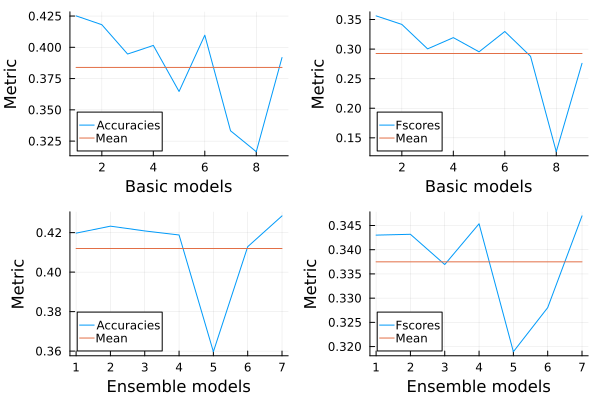

In [12]:
b_acc = plot(basic_accuracies, label = "Accuracies", xaxis = "Basic models", yaxis = "Metric",legend=:bottomleft) 
plot!(b_acc,mean_basic_accuracies, label = "Mean")
b_fscore = plot(basic_fscores, label = "Fscores", xaxis = "Basic models", yaxis = "Metric",legend=:bottomleft)
plot!(b_fscore,mean_basic_fscores, label = "Mean")

e_acc = plot(ensemble_accuracies, label = "Accuracies", xaxis = "Ensemble models", yaxis = "Metric",legend=:bottomleft) 
plot!(e_acc,mean_ensemble_accuracies, label = "Mean")
e_fscore = plot(ensemble_fscores, label = "Fscores", xaxis = "Ensemble models", yaxis = "Metric",legend=:bottomleft)
plot!(e_fscore,mean_ensemble_fscores, label = "Mean")

plot(b_acc, b_fscore, e_acc, e_fscore , layout = (2,2))